**Check the final dashboard here:** [Tableau Dashboard](https://public.tableau.com/app/profile/matteo.ladislai/viz/Book17_17092189657550/Dashboard2)

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime, date 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [29]:
path = r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Petrignano\Aquifer_Petrignano.csv'
df = pd.read_csv(path)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [30]:
# Remove not usefull columns
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [31]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  4199 non-null   object 
 1   rainfall              4199 non-null   float64
 2   depth_to_groundwater  4172 non-null   float64
 3   temperature           4199 non-null   float64
 4   drainage_volume       4198 non-null   float64
 5   river_hydrometry      4199 non-null   float64
dtypes: float64(5), object(1)
memory usage: 197.0+ KB


## Data cleaning

In [33]:
# Parse object type to datetime type
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [34]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

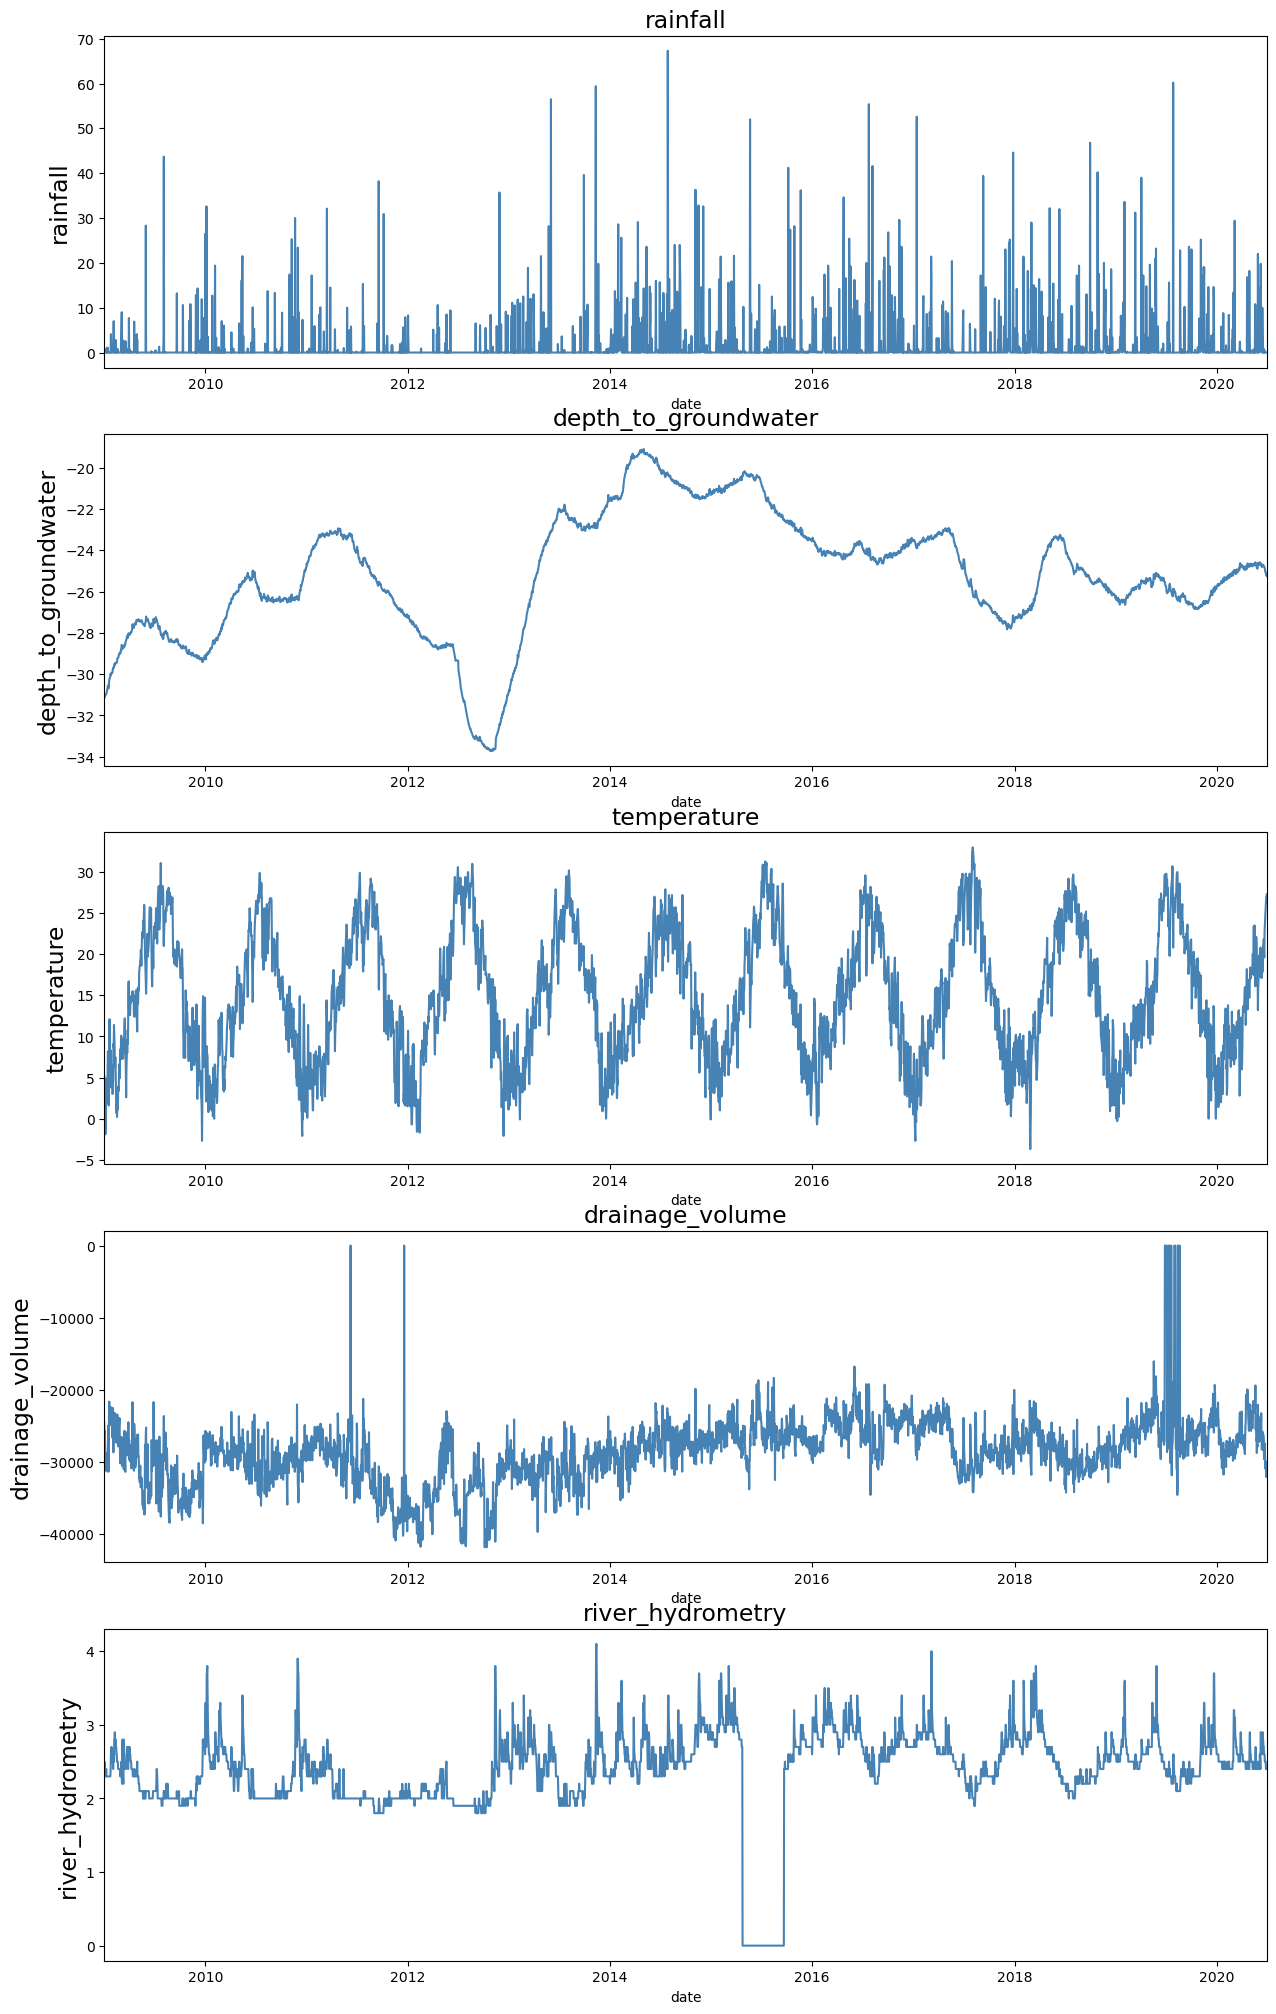

In [35]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    # For now I handle missing value with fillna
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='steelblue')
    ax[i].set_title(column, fontsize=17)
    ax[i].set_ylabel(column, fontsize=17)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])     

I see no reasons why the river_hydrometry would be 0 just before 2016. This is likely a bias in the data, so I'll convert values == 0 to np.nan.

In [36]:
df['river_hydrometry_back_up'] = df['river_hydrometry'].copy()
df.loc[df['river_hydrometry']==0, 'river_hydrometry'] = np.nan

# Fill nan values with interpolate
df['hydro_fill'] = df['river_hydrometry'].interpolate()

# This is for the next visualization
df.loc[df['river_hydrometry'].notna(), 'hydro_fill'] = np.nan

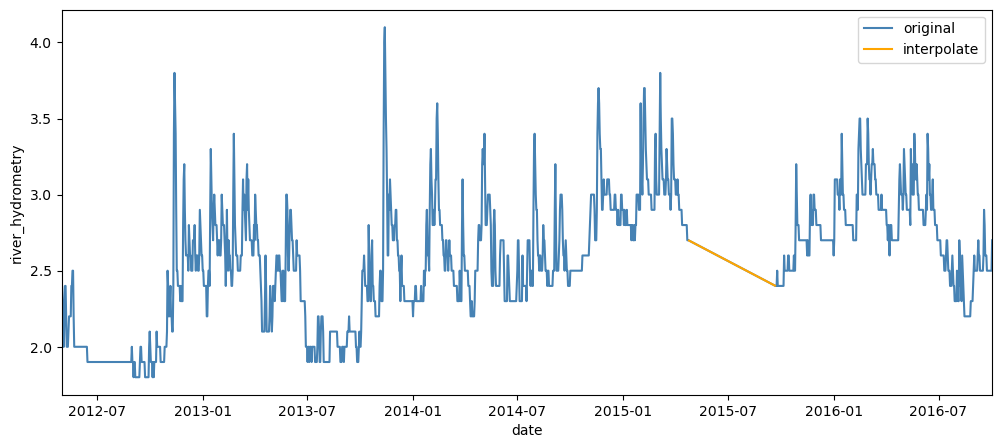

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(x=df['date'], y=df['river_hydrometry'], color='steelblue',
             label='original', ax=ax)
sns.lineplot(x=df['date'], y=df['hydro_fill'], color='orange',
             label='interpolate', ax=ax)
ax.set_xlim([date(2012, 5, 1), date(2016, 10, 1)])
plt.show()

In [38]:
# interpolate in this case is quite good, so I'll use it for each of the columns

df.loc[df['depth_to_groundwater']==0, 'depth_to_groundwater'] = np.nan
df.loc[df['river_hydrometry']==0, 'river_hydrometry'] = np.nan

df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()
df.drop(columns=['hydro_fill', 'river_hydrometry_back_up'], inplace=True)

df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [40]:
df.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Petrignano\4 tableau\daily_values.csv',
          index=False)

## Resampling

It's almost impossible to predict the depth_to_groundwater daily. There are just too many random factors that influence the daily level. Hence, we'll resemple the data.

Each row will be the weekly average.

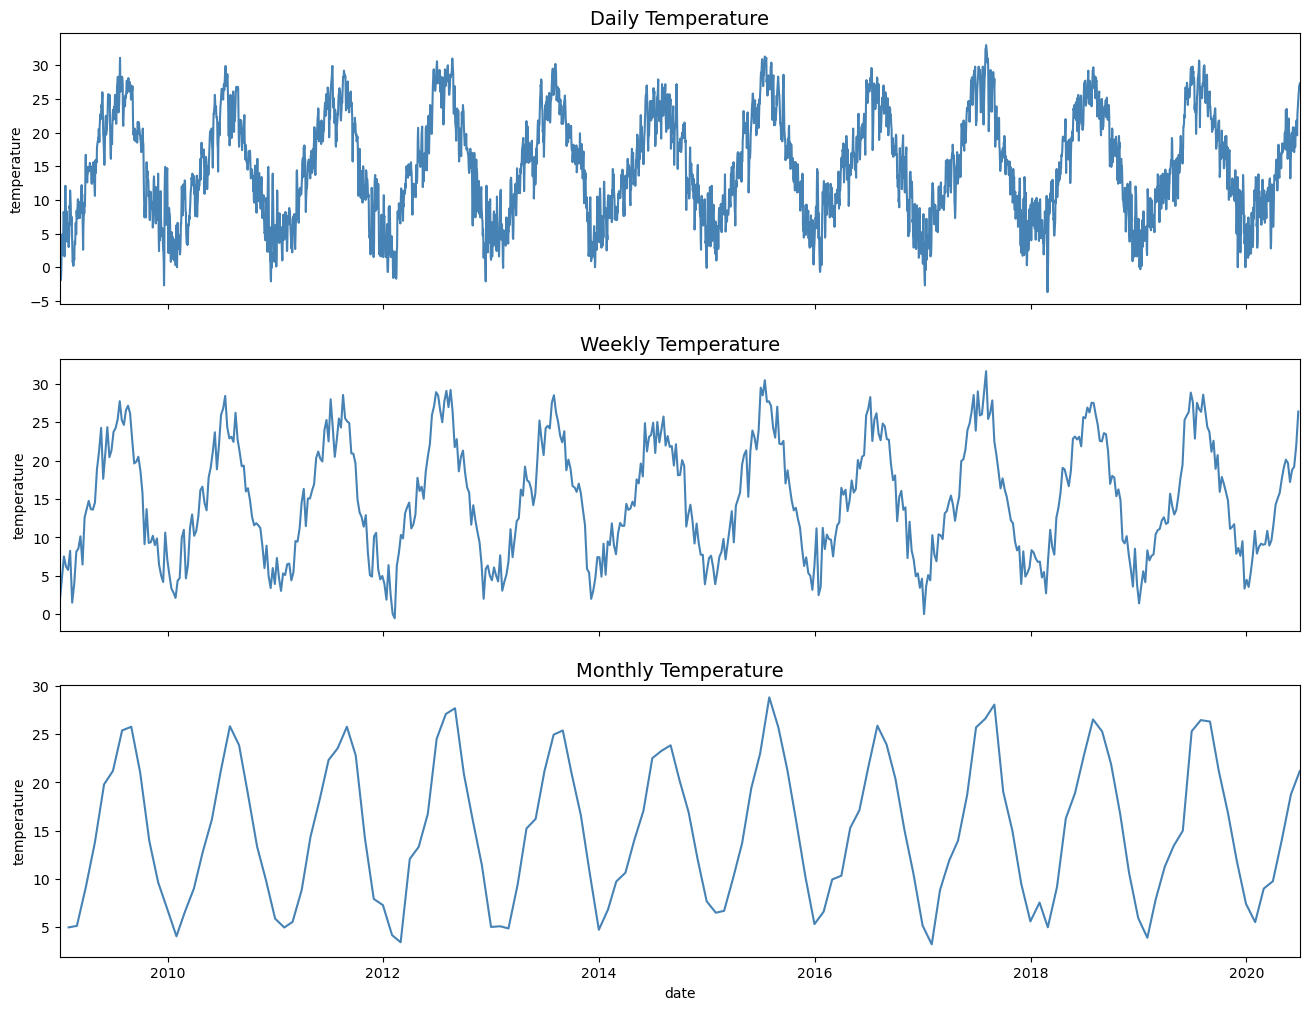

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['temperature'], color='steelblue', ax=ax[0])
ax[0].set_title('Daily Temperature', fontsize=14)

weekly_temp = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=weekly_temp['date'], y=weekly_temp['temperature'], color='steelblue', ax=ax[1])
ax[1].set_title('Weekly Temperature', fontsize=14)

monthly_temp = df[['date','temperature']].resample('1M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=monthly_temp['date'], y=monthly_temp['temperature'], color='steelblue', ax=ax[2])
ax[2].set_title('Monthly Temperature', fontsize=14)

for i in range(3):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [39]:
# I'll downsample to weekly so it's easier to predict

downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Data Preprocessing

In [40]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['quarter'] = df['date'].dt.quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'quarter','season']].head()

,date,year,month,day,day_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1
1,2009-01-08,2009,1,8,8,1,1
2,2009-01-15,2009,1,15,15,1,1
3,2009-01-22,2009,1,22,22,1,1
4,2009-01-29,2009,1,29,29,1,1


In [41]:
# encoding cyclical features

df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)

In [42]:
# timeseries decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

to_decompose = [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in to_decompose:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

In [43]:
df.head()

,date,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,rainfall,year,month,day,day_of_year,...,rainfall_trend,rainfall_seasonal,temperature_trend,temperature_seasonal,drainage_volume_trend,drainage_volume_seasonal,river_hydrometry_trend,river_hydrometry_seasonal,depth_to_groundwater_trend,depth_to_groundwater_seasonal
0,2009-01-01,-31.048571,1.657143,-28164.918857,2.371429,0.000000,2009,1,1,1,...,0.806294,0.688948,15.329959,-9.739920,-32404.467037,1465.324852,2.164913,0.295306,-29.571657,-0.643767
1,2009-01-08,-30.784286,4.571429,-29755.789714,2.314286,0.285714,2009,1,8,8,...,0.809093,-0.728055,15.312814,-9.838787,-32374.371773,852.060183,2.167252,0.274285,-29.535110,-0.572078
2,2009-01-15,-30.420000,7.528571,-25463.190857,2.300000,0.028571,2009,1,15,15,...,0.811892,-0.717139,15.295668,-10.002955,-32344.276508,683.230538,2.169592,0.193182,-29.498564,-0.484281
3,2009-01-22,-30.018571,6.214286,-23854.422857,2.500000,0.585714,2009,1,22,22,...,0.814691,0.493481,15.278522,-9.973161,-32314.181244,355.982452,2.171931,0.219752,-29.462017,-0.417712
4,2009-01-29,-29.790000,5.771429,-25210.532571,2.500000,1.414286,2009,1,29,29,...,0.817490,-0.556499,15.261377,-10.246938,-32284.085980,65.586895,2.174270,0.240426,-29.425470,-0.362900


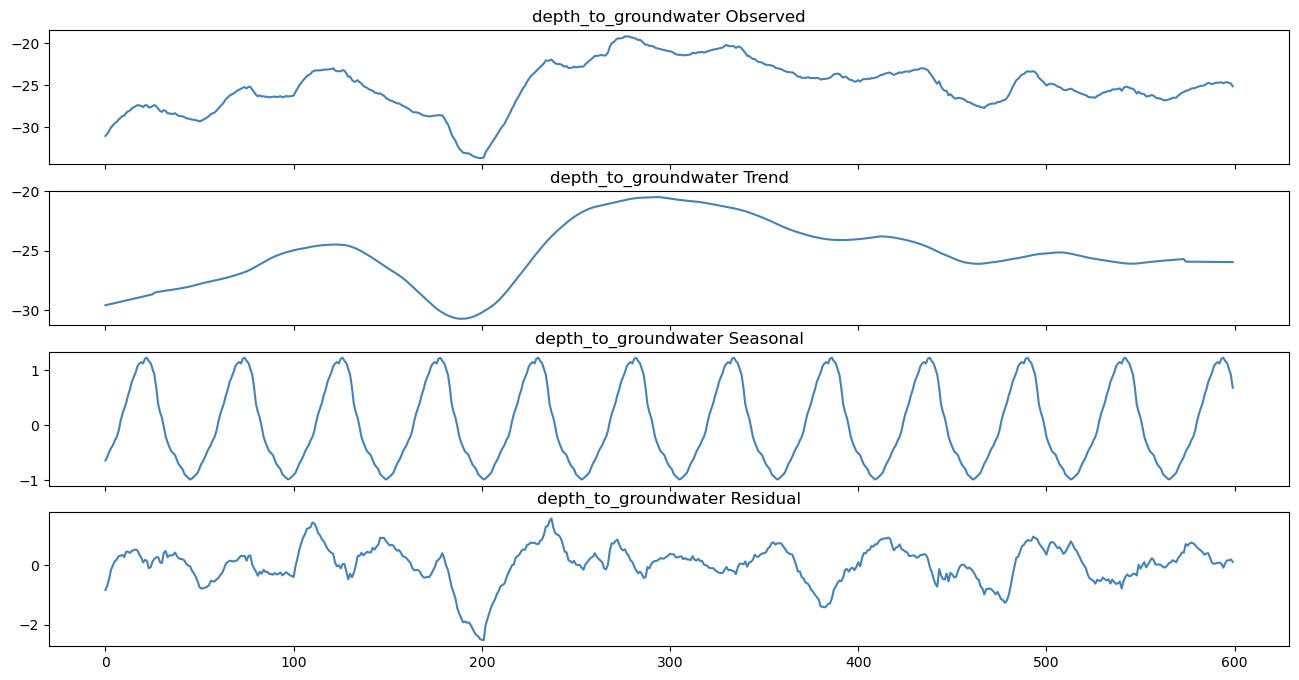

In [44]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
col = 'depth_to_groundwater'

res = seasonal_decompose(df[col], period=52, model='additive',
                         extrapolate_trend = 'freq')

ax[0].set_title(f'{col} Observed')
res.observed.plot(ax= ax[0], legend=False, color='steelblue')

ax[1].set_title(f'{col} Trend')
res.trend.plot(ax=ax[1], legend=False, color='steelblue')

ax[2].set_title(f'{col} Seasonal')
res.seasonal.plot(ax=ax[2], legend=False, color='steelblue')

ax[3].set_title(f'{col} Residual')
res.resid.plot(ax=ax[3], legend=False, color='steelblue')

plt.show()

In [45]:
# Temperature and rainfall don't immidiately influence the water level.
# So we'll shift them.

for column in to_decompose:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * 4) #4=weeks_in_month
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * 4)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * 4)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * 4)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * 4)

### Correlation

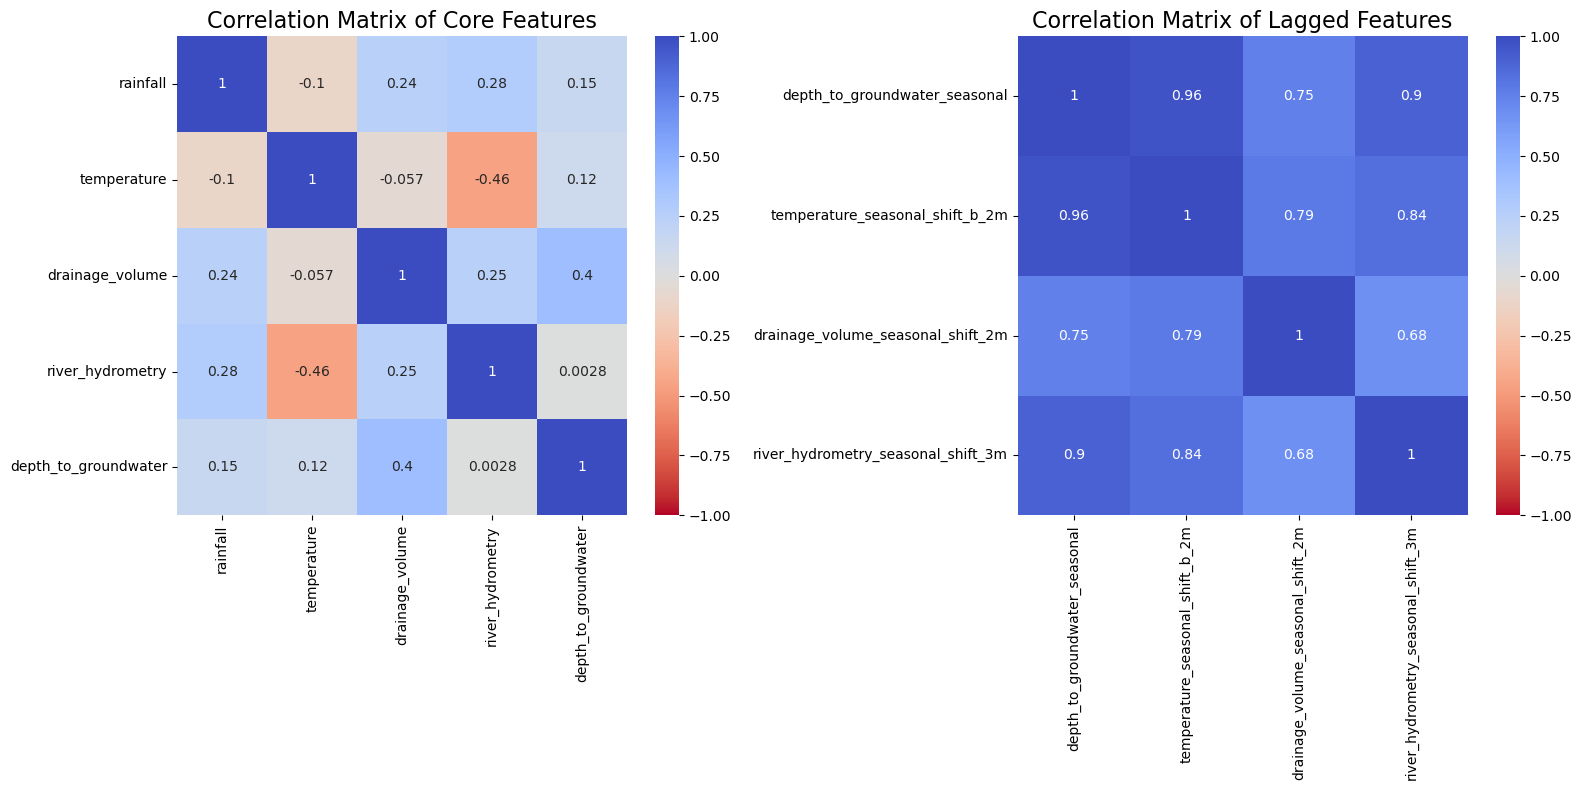

In [46]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[to_decompose].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

In [52]:
df[to_decompose].corr().to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Petrignano\4 tableau\corr_matrix_normal.csv')
df[to_decompose].corr()

,rainfall,temperature,drainage_volume,river_hydrometry,depth_to_groundwater
rainfall,1.000000,-0.103933,0.242981,0.281407,0.148775
temperature,-0.103933,1.000000,-0.056979,-0.457835,0.115366
drainage_volume,0.242981,-0.056979,1.000000,0.247127,0.402501
river_hydrometry,0.281407,-0.457835,0.247127,1.000000,0.002796
depth_to_groundwater,0.148775,0.115366,0.402501,0.002796,1.000000


In [53]:
df[shifted_cols].corr().to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Petrignano\4 tableau\corr_matrix_shift.csv')
df[shifted_cols].corr()

,depth_to_groundwater_seasonal,temperature_seasonal_shift_b_2m,drainage_volume_seasonal_shift_2m,river_hydrometry_seasonal_shift_3m
depth_to_groundwater_seasonal,1.000000,0.961653,0.754727,0.899721
temperature_seasonal_shift_b_2m,0.961653,1.000000,0.785226,0.839125
drainage_volume_seasonal_shift_2m,0.754727,0.785226,1.000000,0.675689
river_hydrometry_seasonal_shift_3m,0.899721,0.839125,0.675689,1.000000


## Machine Learning Prediction

In [47]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [48]:
from prophet import Prophet

# Train the model
model = Prophet()
model.fit(train)

y_hat = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_hat.tail(test_size)['yhat'])
score_rmse = np.sqrt(mean_squared_error(y_valid, y_hat.tail(test_size)['yhat']))

print(f'RMSE: {score_rmse}')

14:37:30 - cmdstanpy - INFO - Chain [1] start processing
14:37:30 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.1969132721330753


In [72]:
ml_predict = pd.merge(df[['date', 'depth_to_groundwater']], y_hat[['ds', 'yhat']],
         how='outer', left_on='date', right_on='ds')

ml_predict.drop(columns='ds', inplace=True)
ml_predict.tail()

,date,depth_to_groundwater,yhat
595,2020-05-28,-24.697143,-26.122581
596,2020-06-04,-24.638571,-26.148812
597,2020-06-11,-24.751429,-26.203053
598,2020-06-18,-24.822857,-26.305481
599,2020-06-25,-25.145000,-26.468179


In [73]:
ml_predict.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Petrignano\4 tableau\predictions.csv',
             index=False)

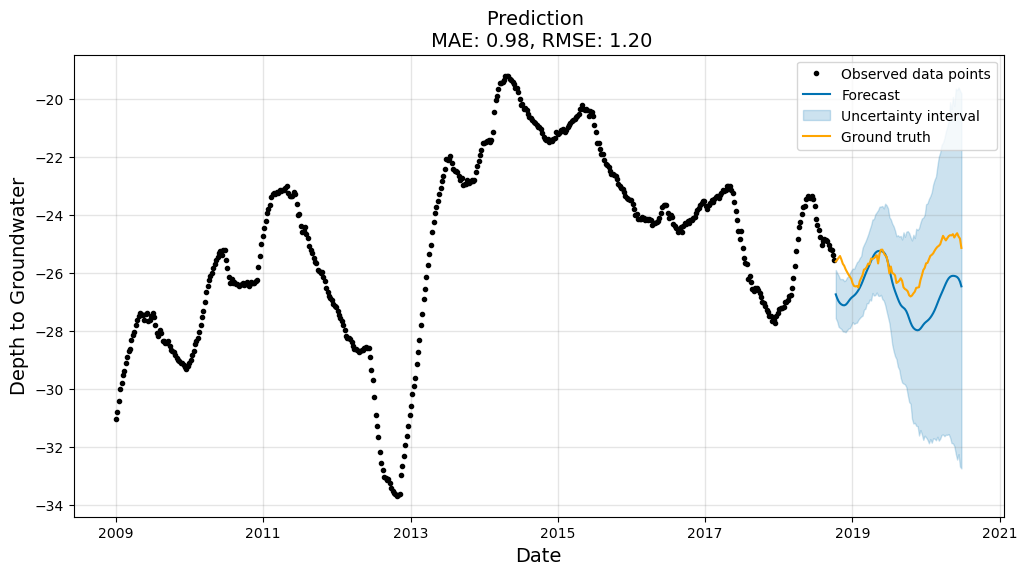

In [49]:
fig, ax = plt.subplots(figsize=(12,6))

model.plot(y_hat, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()